In [1]:
import geopandas as gpd
import pandas as pd

# Data Cleaning

In [2]:
sales = pd.read_parquet('sale_sample_18-21.parquet')
townships = gpd.read_file('townships.geojson')
sales.rename(columns={'township_code': 'township'}, inplace=True)
sales.year = sales.year.astype(int)
sales.pin = sales.pin.astype(int)
#sales.township = sales.township.astype(int)
#townships.township = townships.township.astype(int)

town_sales = sales.merge(townships, on='township')

In [3]:
town_sales

,pin,year,township,class,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,is_sale_leaseback,is_homestead_exemption,homestead_exemption_general_alternative,homestead_exemption_senior_citizens,homestead_exemption_senior_citizens_assessment_freeze,shape_area,area_no,range,shape_len,geometry
0,24081290130000,2022,39,203,2022-02-28 00:00:00+00:00,165000.0,5.217484,7323370.0,2207407612,01,...,None,None,NaN,NaN,NaN,650696208.311,17,14,150087.456864,"MULTIPOLYGON (((-87.62465 41.91127, -87.62465 ..."
1,24081290130000,2022,39,203,2022-02-28 00:00:00+00:00,165000.0,5.217484,7323370.0,2207407612,01,...,None,None,NaN,NaN,NaN,1027545153.82,16,13,128196.679412,"MULTIPOLYGON (((-87.80550 41.90152, -87.80552 ..."
2,24081290130000,2022,39,203,2022-02-28 00:00:00+00:00,165000.0,5.217484,7323370.0,2207407612,01,...,None,None,NaN,NaN,NaN,1010249291.83,15,12,126908.248905,"MULTIPOLYGON (((-87.91698 41.81855, -87.91828 ..."
3,24101270370000,2022,39,203,2022-03-28 00:00:00+00:00,313900.0,5.496791,7322200.0,2209021103,01,...,None,None,NaN,NaN,NaN,650696208.311,17,14,150087.456864,"MULTIPOLYGON (((-87.62465 41.91127, -87.62465 ..."
4,24101270370000,2022,39,203,2022-03-28 00:00:00+00:00,313900.0,5.496791,7322200.0,2209021103,01,...,None,None,NaN,NaN,NaN,1027545153.82,16,13,128196.679412,"MULTIPOLYGON (((-87.80550 41.90152, -87.80552 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180756,19311170290000,2018,36,234,2018-10-01 00:00:00+00:00,180600.0,5.256718,96965893.0,1830418080,05,...,0,0,0.0,0.0,0.0,1055215444.41,28,13,132996.607446,"MULTIPOLYGON (((-87.79544 41.63888, -87.79573 ..."
180757,19293000390000,2018,36,234,2018-10-01 00:00:00+00:00,225000.0,5.352183,96223541.0,1830218044,01,...,0,0,0.0,0.0,0.0,1028296887.78,29,14,135233.596762,"MULTIPOLYGON (((-87.67970 41.64815, -87.67527 ..."
180758,19293000390000,2018,36,234,2018-10-01 00:00:00+00:00,225000.0,5.352183,96223541.0,1830218044,01,...,0,0,0.0,0.0,0.0,1014943493.86,27,12,127411.604304,"MULTIPOLYGON (((-87.91171 41.63669, -87.91193 ..."
180759,19293000390000,2018,36,234,2018-10-01 00:00:00+00:00,225000.0,5.352183,96223541.0,1830218044,01,...,0,0,0.0,0.0,0.0,292968083.009,30,15,81900.1472079,"MULTIPOLYGON (((-87.55925 41.63719, -87.55930 ..."


# Variance - Outlier Detection

Just check number of deivations away from mean grouped by township.

Problems:

Would like to vary by geography, but how to join new geographies to table to do that? What is value in common? With spatial dataset could see what PINS in what unit, but we have no lat/long for data.


In [4]:
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 5)
    upper_limit = s.mean() + (s.std() * 5)
    return ~s.between(lower_limit, upper_limit)

outliers = sales[sales.groupby('township')['sale_price_log10'].apply(is_outlier)]
no_outliers = sales[~sales.groupby('township')['sale_price_log10'].apply(is_outlier)]

<AxesSubplot:ylabel='Frequency'>

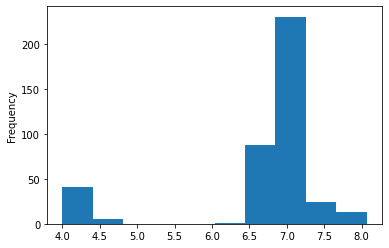

In [5]:
outliers.sale_price_log10.plot.hist()

<AxesSubplot:ylabel='Frequency'>

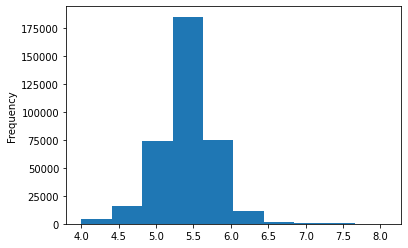

In [6]:
sales.sale_price_log10.plot.hist()

<AxesSubplot:ylabel='Frequency'>

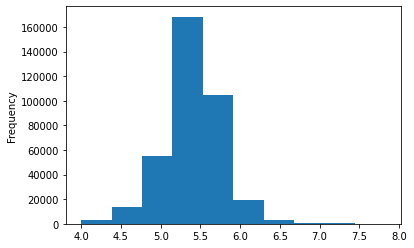

In [7]:
no_outliers.sale_price_log10.plot.hist()

# Growth Rates

Get average % change in price for properties in township for all time and then mark outlier properties. Get clarification on Growth Rate vs Sale Price Volatility

In [34]:
sales['pct'] = sales.sort_values('sale_date').groupby('pin')['sale_price'].pct_change()
township_growth = sales.groupby('township')['pct'].mean()
sales.set_index('township', inplace=True)
sales['township_growth'] = township_growth
sales.reset_index(inplace=True)

In [35]:
sales

,township,pin,year,class,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,is_buyer_an_adjacent_property_owner,is_buyer_exercising_an_option_to_purchase,is_simultaneous_trade_of_property,is_sale_leaseback,is_homestead_exemption,homestead_exemption_general_alternative,homestead_exemption_senior_citizens,homestead_exemption_senior_citizens_assessment_freeze,pct,township_growth
0,29,2092050370000,2019,295,2019-05-01 00:00:00+00:00,201000.0,5.303196,96812985.0,1915417094,01,...,0,0,0,0,0,0.0,0.0,0.0,NaN,0.359327
1,72,20311070380000,2019,205,2019-09-01 00:00:00+00:00,215000.0,5.332438,98075139.0,1927355080,01,...,0,0,0,0,0,0.0,0.0,0.0,NaN,1.874699
2,24,10201120410000,2018,206,2018-07-01 00:00:00+00:00,540000.0,5.732394,97373057.0,1822817046,01,...,0,0,0,0,0,0.0,0.0,0.0,NaN,0.517396
3,27,16183030040000,2022,203,2022-02-11 00:00:00+00:00,595000.0,5.774517,7321053.0,2206001050,01,...,None,None,None,None,None,NaN,NaN,NaN,NaN,0.516751
4,24,10272320440000,2020,203,2020-04-01 00:00:00+00:00,285000.0,5.454845,96592558.0,2019607192,01,...,0,0,0,0,0,0.0,0.0,0.0,NaN,0.517396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368060,35,7262000211004,2018,299,2018-04-01 00:00:00+00:00,173000.0,5.238046,97001692.0,1812729171,01,...,0,0,0,0,0,0.0,0.0,0.0,NaN,0.362495
368061,35,7243030171010,2018,299,2018-11-01 00:00:00+00:00,172000.0,5.235528,96594757.0,1831757035,02,...,0,0,0,0,0,0.0,0.0,0.0,NaN,0.362495
368062,24,10341020221059,2020,299,2020-03-01 00:00:00+00:00,213000.0,5.328380,97408348.0,2007147087,01,...,0,0,0,0,1,932.0,0.0,0.0,-0.130612,0.517396
368063,77,13251310310000,2018,203,2018-05-01 00:00:00+00:00,625000.0,5.795880,96260041.0,1815912107,01,...,0,0,0,0,0,0.0,0.0,0.0,NaN,1.003418


# Sale Volatility

In [41]:
sales['pin'].value_counts()

17103180800000    123
8121220400000      22
17171020430000     20
5272000010000      17
20131030090000     16
                 ... 
7243000051018       1
29152140070000      1
20224110460000      1
27254010210000      1
3284060770000       1
Name: pin, Length: 327398, dtype: int64

In [ ]:
sales[sales[''].isin(sales[''].value_counts()[sales[''].value_counts()>2].index)]